## Week 4: Evaluation Metrics

### 4.1 Evaluation Metrics: Session Overview

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [5]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

df.columns = df.columns.str.lower().str.replace(' ','_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')
    
df.totalcharges = pd.to_numeric(df.totalcharges, errors = 'coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [6]:
df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state = 1)
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state = 1) #20% of 80%

df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [7]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents', 
    'phoneservice', 'multiplelines', 'internetservice',
    'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
    'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling','paymentmethod']

In [9]:
dv = DictVectorizer(sparse = False)

train_dicts = df_train[categorical + numerical].to_dict(orient = 'records')
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(max_iter = 10000)
model.fit(X_train,y_train)

LogisticRegression(max_iter=10000)

In [10]:
val_dicts = df_val[categorical + numerical].to_dict(orient = 'records')
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:,1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8026969481902059

### 4.2 Accuracy and dummy model

- Evaluate the model on different thresholds
- Check the accuracy of dummy baselines


(Is the 80% accuracy enough?)

In [14]:
(y_val == churn_decision).sum() #total correct decisions

1131

In [16]:
len(y_val) #total number of customers

1409

In [18]:
1132/1409 #--> accuracy

0.8034066713981547

In [28]:
thresholds = np.linspace(0,1,21)

scores = []

for t in thresholds:
    churn_decision = (y_pred >= t)
    score = (y_val == churn_decision).mean()
    #print("%.2f %.3f"%(t,score))
    scores.append(score)

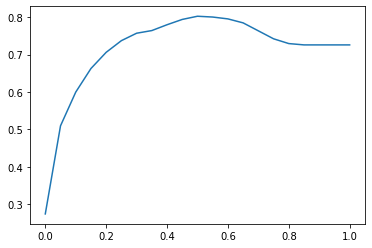

In [29]:
plt.plot(thresholds, scores) #we see that 0.5 is the most accurate

In [30]:
from sklearn.metrics import accuracy_score

In [32]:
thresholds = np.linspace(0,1,21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    #print("%.2f %.3f"%(t,score))
    scores.append(score)

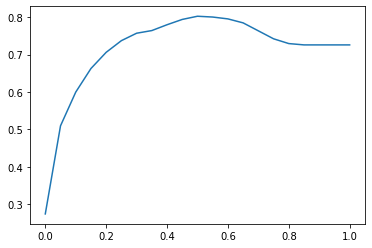

In [33]:
plt.plot(thresholds, scores) #we see that 0.5 is the most accurate

We see that the dummy model (threshold = 1.0) is only 7% less accurate than our model. So we see that accuracy is not the best way to evaluate a model bc if it is, 7% is not a significant increase in accuracy.

We actually have a class imbalance here (more unchurning people than churning people) which means the dummy model will already have a good accuracy.

So accuracy is not a good metric when we have class imbalance.

In [34]:
from collections import Counter

In [35]:
Counter(y_pred>= 1.0)

Counter({False: 1409})

### 4.3 Confusion table

- Different types of errors and correct decisions
- Arranging them in a table

(False positives and false negatives)

In [42]:
actual_positive = (y_val == 1) #customers that are actually churning
actual_negative = (y_val == 0) #customers that didn't churn

In [43]:
t = 0.5
predict_positive = (y_pred >= 0.5) #predicted customers that will churn
predict_negative = (y_pred < 0.5)

In [44]:
tp = (predict_positive & actual_positive).sum() #return true if both are true
tn = (predict_negative & actual_negative).sum() #true negative
fp = (predict_positive & actual_negative).sum() #false positive
fn = (predict_negative & actual_positive).sum() #false negative

In [47]:
confusion_matrix = np.array([
    [tn,fp],
    [fn, tp]
])

confusion_matrix

array([[917, 106],
       [172, 214]])

We have a lot more false negatives than false positives (more difficult to catch)

In [49]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.08],
       [0.12, 0.15]])

We know that out accuracy us 80%. In that 80% we predicted 65% true negative and 15% true positive

### 4.4 Precision and Recall

### 4.5 ROC Curves

#### TPR and FRP

#### Random Model

#### Ideal Model

### 4.6 ROC AUC

- Area under the ROC curve - useful metric
- Interpretation of AUC

### 4.7 Cross-Validation

- Evaluating the same model on different subsets of data
- Getting the average prediction and the spread within predictions

### 4.8 Summary

- Metric - a single number that describes the performance of a model
- Accuracy - fraction of correct answers; sometimes misleading
- Precision and recall are less misleading when we have class imbalance
- ROC Curve - a way to evaluate the performance at all thresholds; okay to use the imbalance
- K-Fold CV - more reliable estimate for performance (mean + std)